# Sine Wave

## Uniform Sampling

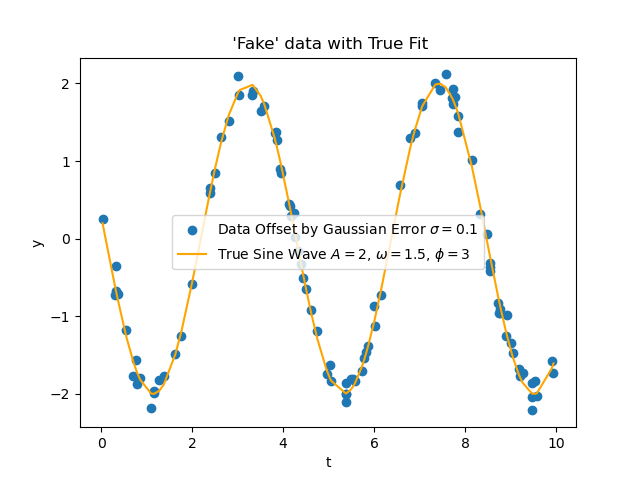

In [24]:
%matplotlib widget

import dynesty
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(142)

# true model is described by three parameters: A, omega and phi.
omega_true = 1.5
phi_true = 3
A_true = 2
N = 100
sigma = 0.1 # defines the width of the normal distribution from which the errors in y are drawn

#find the true points on the line
t = np.sort(10*np.random.rand(N)) # random x values between 0 and 10
y = A_true*np.sin(omega_true*t + phi_true) # true y values for each x
y_error = np.random.normal(loc=0, scale=sigma, size = N) # draw vector of N points from normal distribution with width sigma
y_new = y + y_error

plt.scatter(t, y_new,label='Data Offset by Gaussian Error $\sigma=$' + str(sigma))
plt.plot(t, y, "orange", label='True Sine Wave $A=$' + str(A_true) + ', $\omega=$' + str(omega_true) + ', $\phi=$' + str(phi_true))  # true model
plt.xlabel('t')
plt.ylabel('y')
plt.title(' \'Fake\' data with True Fit')
plt.legend()

In [2]:
import scipy.stats as sts

def model(A,omega,phi):
    model = A*np.sin(omega*t + phi)
    return model

def prior_transform(utheta): #parameter theta drawn uniform distribution between zero and one.
    uA, uOmega, uPhi = utheta
    A = 4*uA + 1 #prior: A is uniformly selected between 1 and 4
    omega = uOmega + 1 #prior: omega is uniformly selected between 1 and 2
    phi = 2*np.pi*uPhi #prior: phi is uniformly selected between 0 and 2*pi
    return A, omega, phi

def lnlike(theta): #same parameter function?
    A, omega, phi = theta
    y_val = model(A,omega,phi)
    return sum(sts.norm.logpdf(y_new, loc=y_val, scale=sigma))

dsampler = dynesty.DynamicNestedSampler(lnlike, prior_transform, ndim=3)
dsampler.run_nested()
dresults = dsampler.results


24861it [01:10, 350.81it/s, batch: 11 | bound: 66 | nc: 2 | ncall: 62244 | eff(%): 39.941 | loglstar: -158.693 < -150.213 < -150.841 | logz: -158.906 +/-  0.163 | stop:  0.933]     


In [12]:
sum(sts.norm.logpdf(y_new, loc=model(2, 1.5, 3), scale=10))


-322.7486234639604

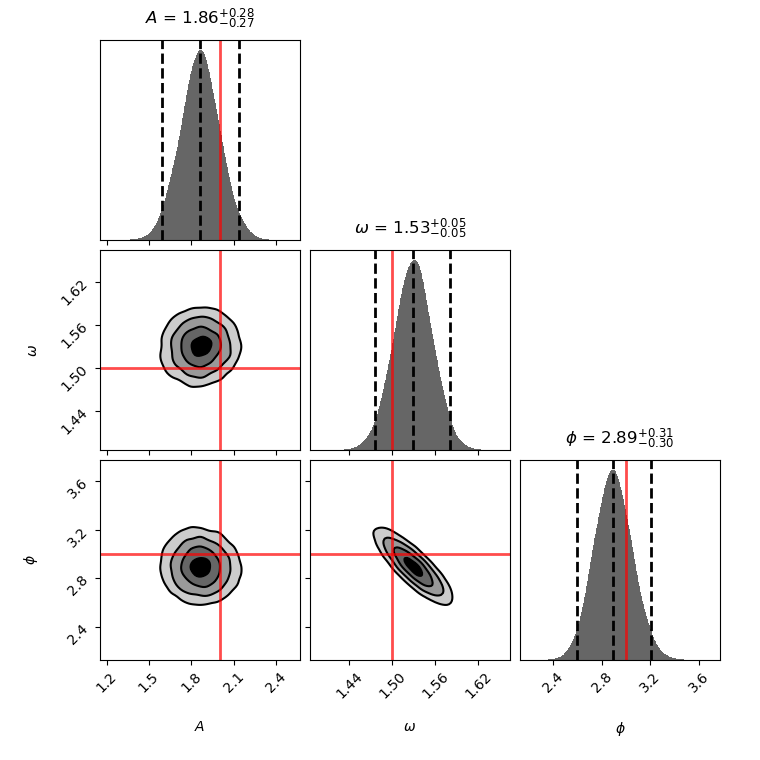

In [3]:
from dynesty import plotting as dyplot
from numpy import *

fig, axes = dyplot.cornerplot(dresults, truths=[A_true,omega_true,phi_true], show_titles=True,title_kwargs={'y': 1.04}, labels=['$A$','$\omega$','$\phi$'])

plt.savefig('corner-plot-sine.png')

In [4]:
lnZ = dresults.logz[-1] #select last element of cumulative log z array
lnZ_err = dresults.logzerr[-1] #select last element of cumulative log z error array

print("log(Z) = {0:1.4} ± {1:1.4}".format(lnZ, lnZ_err))

log(Z) = -158.9 ± 0.1623


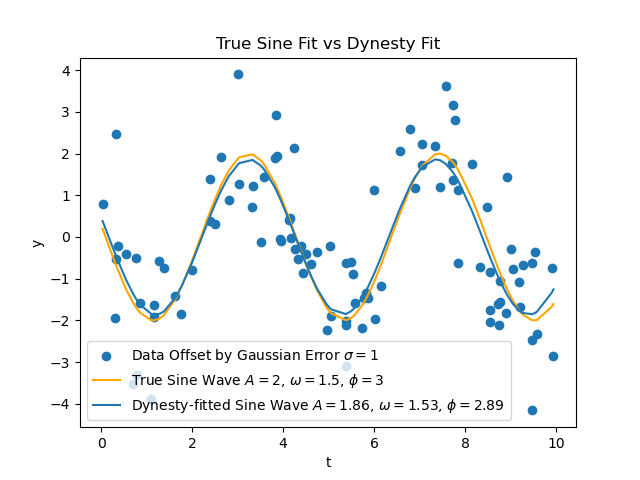

In [13]:
A, omega, phi = dresults.samples[-1]

plt.figure()
plt.scatter(t, y_new,label='Data Offset by Gaussian Error $\sigma=$' + str(sigma))
plt.plot(t, y, "orange", label='True Sine Wave $A=$' + str(A_true) + ', $\omega=$' + str(omega_true) + ', $\phi=$' + str(phi_true))  # true model
plt.plot(t,A*np.sin(omega*t+phi),label='Dynesty-fitted Sine Wave $A={0:1.2f}$, $\omega={1:1.2f}$, $\phi={2:1.2f}$'.format(A,omega,phi))
plt.legend()
plt.title('True Sine Fit vs Dynesty Fit')
plt.xlabel('t')
plt.ylabel('y')

plt.savefig('sine-fit.png')

## Sampling Windows

### Periodic sampling window

Here, we imagine the instrument samples for *one time unit* with one unit breaks in between these windows.

So for the data, we include points between 0 and 1, then discard 1 to 2, then take 2 to 3, and so on.

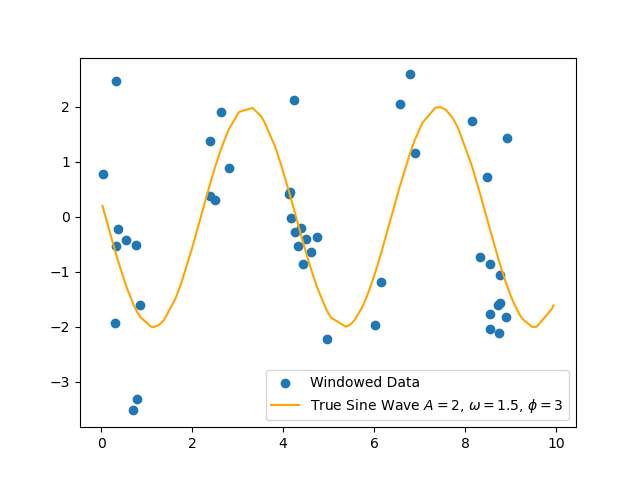

In [14]:
t_windowed = t
y_windowed = y_new

def sampling_window(t,y_new):
    t_windowed = t
    y_windowed = y_new
    indices = []
    for i in range(0,len(t_windowed)):
        for j in range(1,6):
            if t_windowed[i] > 1*(2*j-1) and t_windowed[i] < 2*j:
                indices += [i]
    t_windowed = np.delete(t_windowed, indices)
    y_windowed = np.delete(y_windowed, indices)
    return t_windowed, y_windowed, indices

t_windowed, y_windowed, indices = sampling_window(t,y_new)

plt.figure()
plt.scatter(t_windowed, y_windowed, label='Windowed Data')
plt.plot(t, y, "orange", label='True Sine Wave $A=$' + str(A_true) +
         ', $\omega=$' + str(omega_true) + ', $\phi=$' + str(phi_true))  # true model
plt.legend()


In [15]:
import scipy.stats as sts

def model_windowed(A,omega,phi):
    model = A*np.sin(omega*t_windowed + phi)
    return model

def lnlike_windowed(theta): #same parameter function?
    A, omega, phi = theta
    y_val = model_windowed(A,omega,phi)
    return sum(sts.norm.logpdf(y_windowed, loc=y_val, scale=sigma))

dsampler_windowed = dynesty.DynamicNestedSampler(lnlike_windowed, prior_transform, ndim=3)
dsampler_windowed.run_nested()
dresults_windowed = dsampler_windowed.results

17306it [00:43, 401.54it/s, batch: 8 | bound: 52 | nc: 1 | ncall: 55905 | eff(%): 30.956 | loglstar: -71.566 < -64.988 < -65.694 | logz: -72.568 +/-  0.147 | stop:  0.974]        


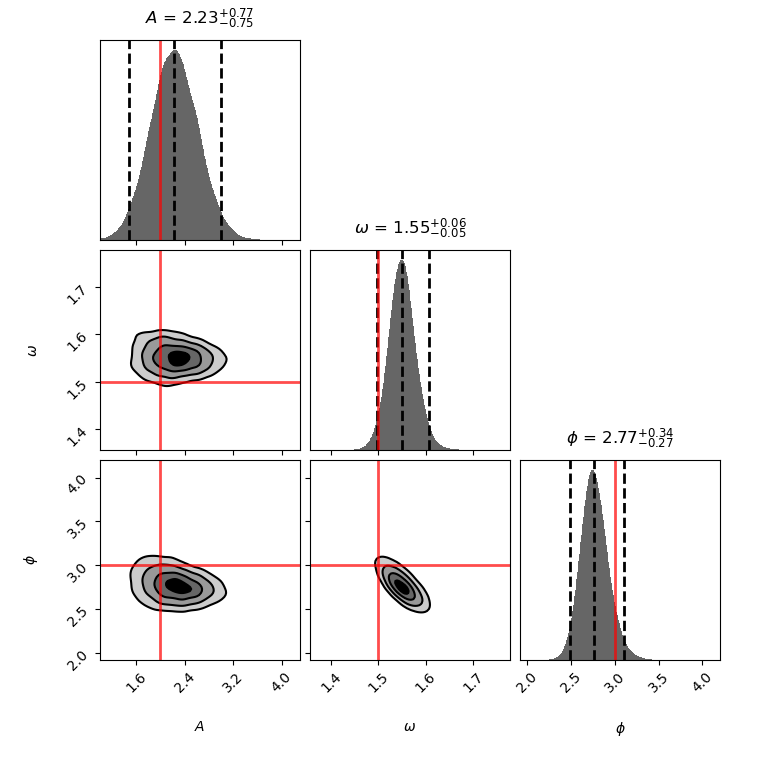

In [16]:
fig, axes = dyplot.cornerplot(dresults_windowed, truths=[A_true,omega_true,phi_true], show_titles=True,title_kwargs={'y': 1.04}, labels=['$A$','$\omega$','$\phi$'])

plt.savefig('corner-plot-sine.windowed.png')

In [12]:
lnZ = dresults_windowed.logz[-1] #select last element of cumulative log z array
lnZ_err = dresults_windowed.logzerr[-1] #select last element of cumulative log z error array

print("log(Z) = {0:1.4} ± {1:1.4}".format(lnZ, lnZ_err))

log(Z) = -72.57 ± 0.1469


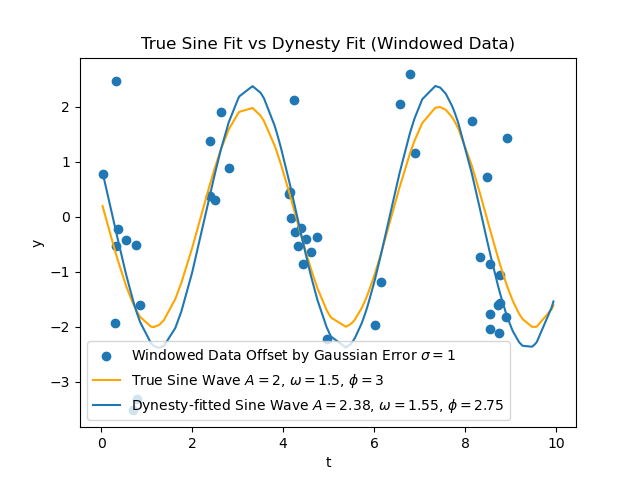

In [17]:
A_windowed, omega_windowed, phi_windowed = dresults_windowed.samples[-1]

plt.figure()
plt.scatter(t_windowed, y_windowed,label='Windowed Data Offset by Gaussian Error $\sigma=$' + str(sigma))
plt.plot(t, y, "orange", label='True Sine Wave $A=$' + str(A_true) + ', $\omega=$' + str(omega_true) + ', $\phi=$' + str(phi_true))  # true model
plt.plot(t, A_windowed*np.sin(omega_windowed*t + phi_windowed),
         label='Dynesty-fitted Sine Wave $A={0:1.2f}$, $\omega={1:1.2f}$, $\phi={2:1.2f}$'.format(A_windowed, omega_windowed, phi_windowed))
plt.legend()
plt.title('True Sine Fit vs Dynesty Fit (Windowed Data)')
plt.xlabel('t')
plt.ylabel('y')

plt.savefig('sine-fit-windowed.png')

### Random sampling window

This code works by turning the t vector into a 2D 10x10 array and then taking randomly spaced windows from that array. The size of the window can be specified. Adapted from https://stackoverflow.com/questions/47982894/selecting-random-windows-from-multidimensional-numpy-array-rows

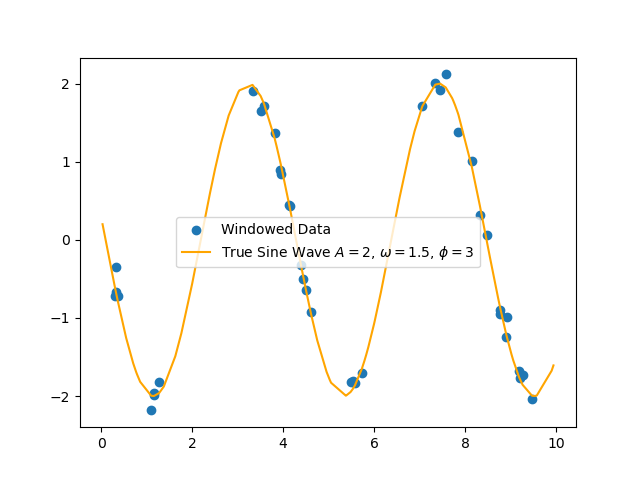

In [25]:
def sampling_window_random(t, y_new, window_size):
    t_windowed_random = t.reshape(10,10)
    y_windowed_random = y_new.reshape(10,10)
    offsets = np.random.randint(0, t_windowed_random.shape[1]-window_size+1, size=t_windowed_random.shape[0])
    return t_windowed_random[np.arange(t_windowed_random.shape[0])[:,None], offsets[:,None] + np.arange(window_size)],y_windowed_random[np.arange(y_windowed_random.shape[0])[:,None], offsets[:,None] + np.arange(window_size)]

t_windowed_random, y_windowed_random = sampling_window_random(t, y_new,4)

plt.figure()
plt.scatter(t_windowed_random, y_windowed_random, label='Windowed Data')
plt.plot(t, y, "orange", label='True Sine Wave $A=$' + str(A_true) +
         ', $\omega=$' + str(omega_true) + ', $\phi=$' + str(phi_true))  # true model
plt.legend()

In [26]:
import scipy.stats as sts

def model_windowed_random(A,omega,phi):
    model = A*np.sin(omega*t_windowed_random + phi)
    return model

def lnlike_windowed_random(theta): #same parameter function?
    A, omega, phi = theta
    y_val = model_windowed_random(A,omega,phi)
    return sum(sts.norm.logpdf(y_windowed_random, loc=y_val, scale=sigma))

dsampler_windowed_random = dynesty.DynamicNestedSampler(lnlike_windowed_random, prior_transform, ndim=3)
dsampler_windowed_random.run_nested()
dresults_windowed_random = dsampler_windowed_random.results

26944it [01:24, 318.02it/s, batch: 11 | bound: 71 | nc: 1 | ncall: 66190 | eff(%): 40.707 | loglstar: 25.923 < 32.798 < 32.126 | logz: 18.582 +/-  0.221 | stop:  0.930]                


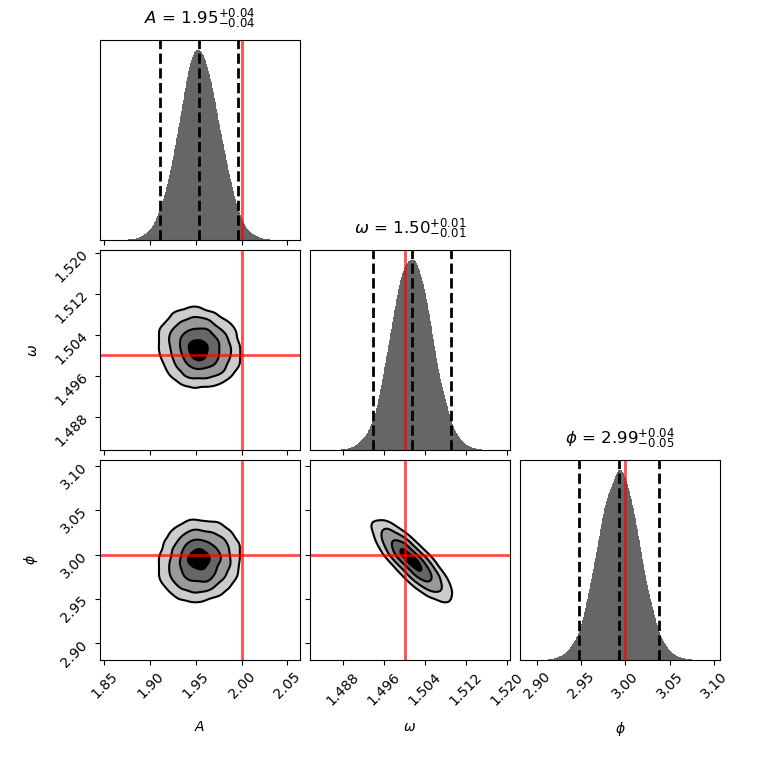

In [27]:
fig, axes = dyplot.cornerplot(dresults_windowed_random, truths=[A_true, omega_true, phi_true], show_titles=True, title_kwargs={
                              'y': 1.04}, labels=['$A$', '$\omega$', '$\phi$'])

# plt.savefig('corner-plot-sine-windowed-random.png')


In [22]:
lnZ = dresults_windowed_random.logz[-1] #select last element of cumulative log z array
lnZ_err = dresults_windowed_random.logzerr[-1] #select last element of cumulative log z error array

print("log(Z) = {0:1.4} ± {1:1.4}".format(lnZ, lnZ_err))

log(Z) = -64.73 ± 0.1021


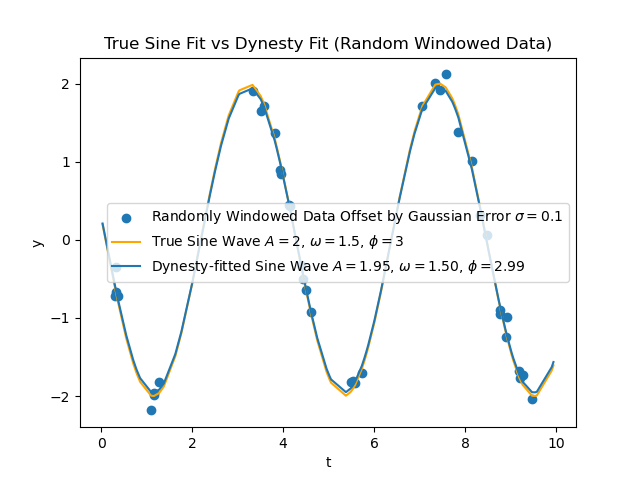

In [28]:
A_windowed_random, omega_windowed_random, phi_windowed_random = dresults_windowed_random.samples[-1]

plt.figure()
plt.scatter(t_windowed_random, y_windowed_random,label='Randomly Windowed Data Offset by Gaussian Error $\sigma=$' + str(sigma))
plt.plot(t, y, "orange", label='True Sine Wave $A=$' + str(A_true) + ', $\omega=$' + str(omega_true) + ', $\phi=$' + str(phi_true))  # true model
plt.plot(t, A_windowed_random*np.sin(omega_windowed_random*t + phi_windowed_random),
         label='Dynesty-fitted Sine Wave $A={0:1.2f}$, $\omega={1:1.2f}$, $\phi={2:1.2f}$'.format(A_windowed_random, omega_windowed_random, phi_windowed_random))
plt.legend()
plt.title('True Sine Fit vs Dynesty Fit (Random Windowed Data)')
plt.xlabel('t')
plt.ylabel('y')

plt.savefig('sine-fit-windowed.png')